This file is for experimenting with how to chop up a table to get an LLM to correctly classify it.

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, Union, Optional
import fitz 

In [58]:
def crop_pdf_page(
    pdf_path: Union[str, Path],
    page_number: int,
    pct_box: Tuple[Tuple[float, float], Tuple[float, float]],
    output_path: Optional[Union[str, Path]] = None,
    output_format: str = "pdf",   # "pdf" (lossless) or "png" (rasterized)
    dpi: int = 400                # only used if output_format="png"
) -> Path:
    """
    Crop a PDF page using percentage-based coordinates.

    Parameters
    ----------
    pdf_path : str | Path
        Input PDF file path.
    page_number : int
        1-based (common) or 0-based page index (>=1 treated as 1-based).
    pct_box : ((x0, x1), (y0, y1))
        Percentages of page width/height in range [0.0, 1.0], where (0,0) is bottom-left.
        Example: ((0.10, 0.80), (0.00, 0.90))  -> like your ((200,800),(0,900)) but as percents.
    output_path : str | Path | None
        Destination file. If a directory or None, a name is generated.
    output_format : "pdf" | "png"
        "pdf" preserves vector content (no quality loss). "png" rasterizes.
    dpi : int
        Rendering resolution for PNG output (ignored for PDF).
    """

    pdf_path = Path(pdf_path)
    if not pdf_path.exists():
        raise FileNotFoundError(f"PDF not found: {pdf_path}")

    page_idx = page_number - 1 if page_number >= 1 else page_number
    if page_idx < 0:
        raise ValueError("page_number must be >= 0 (0-based) or >= 1 (1-based).")

    (px0, px1), (py0, py1) = pct_box
    # clamp & sort percents
    def _clamp(v): return max(0.0, min(1.0, float(v)))
    px0, px1 = sorted((_clamp(px0), _clamp(px1)))
    py0, py1 = sorted((_clamp(py0), _clamp(py1)))
    if px0 == px1 or py0 == py1:
        raise ValueError("Pct crop box has zero area.")

    with fitz.open(pdf_path) as src:
        if page_idx >= len(src):
            raise IndexError(f"PDF has {len(src)} pages; requested {page_idx}.")
        page = src[page_idx]
        pr = page.rect
        # convert percentages to page coordinates (points)
        x0 = pr.x0 + px0 * pr.width
        x1 = pr.x0 + px1 * pr.width
        y0 = pr.y0 + py0 * pr.height
        y1 = pr.y0 + py1 * pr.height
        clip = fitz.Rect(x0, y0, x1, y1)

        # prepare output path
        if output_path is None or Path(output_path).is_dir():
            base = pdf_path.stem
            suffix = f"_p{page_idx+1}_pctx{px0:.3f}-{px1:.3f}_pcty{py0:.3f}-{py1:.3f}"
            if output_format.lower() == "pdf":
                filename = f"{base}{suffix}.pdf"
            else:
                filename = f"{base}{suffix}.png"
            output_path = (Path(output_path) if output_path else pdf_path.parent) / filename
        else:
            output_path = Path(output_path)

        if output_format.lower() == "pdf":
            # LOSSLESS path: create a new PDF page and place the source page clipped
            dst = fitz.open()
            # new page has the size of the clip rect
            new_page = dst.new_page(width=clip.width, height=clip.height)
            # place the original page into the new page with clip; this keeps vectors/images
            new_page.show_pdf_page(
                fitz.Rect(0, 0, clip.width, clip.height),
                src, page.number,
                clip=clip
            )
            dst.save(output_path)
            dst.close()
        elif output_format.lower() == "png":
            # RASTER path: render with lossless PNG (but rasterization is unavoidable)
            zoom = dpi / 72.0
            mat = fitz.Matrix(zoom, zoom)
            pix = page.get_pixmap(matrix=mat, clip=clip, alpha=False)
            pix.save(str(output_path))  # PNG by extension
        else:
            raise ValueError('output_format must be "pdf" or "png".')

    return output_path

# crop_pdf_page('1880.pdf',1,((0,1),(0.315,0.83)),'test_table_X.png', output_format='png')

In [26]:
def display(img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

[   7    8    9   10   19   20   21   22   55  156  200  201  202  290
  337 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751 1752
 1753 1754 1755 1756 1757 1758 1759 1760]


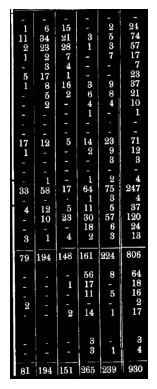

In [57]:
def preprocess_table(table_dir):
    img = cv2.imread(table_dir, cv2.IMREAD_GRAYSCALE)
    th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    proj = np.sum(th,axis=1)
    cut_points = np.where(proj<proj.mean() * 0.3)[0]
    print(cut_points)

    display(th)

test_table = 'test_table_nums_only.png'
preprocess_table(test_table)